# Population Diversity Evolution

In this notebook we test claims on how the TS-DE approach converges. More specifically, we test if the TS-DE approach first diversifies and then focuses on optimization to the optimal solution. And additionally, we test whether the population first diversifies and then focuses and converges to the optimal solution. While the experiments in `EvolvingPopulation2D.ipynb` try to support the same claim, we aim to remove the randomness from the equation in this experiment, since the aforementioned notebooks draw conclusions on a single evaluation. In this experiment we run multiple evaluations and include uncertainty in the results.

In [1]:
%%time

import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sys.path.append('../')

from util.common import zero_population, linear_bayesian_utility_model
from util.TS_DE.TS_DE import TS_DE


CPU times: total: 15.6 ms
Wall time: 14.7 ms


**Parameter setup:**
- *d=40*
- *M=20*
- *T=60*
- *mu=0.1*
- *sigma=1*
- *lambda_=1*

**Claims we are testing:**
(5) TS-DE first diversifies and then concentrates around the optimal solution.

In [2]:
%%time

np.random.seed(seed=0)

# Initial setting for TS-DE and DE
d = 40
M = 20
T = 100
mu = 0.1

# Theta star - optimal theta - parametrization of the linear Bayesian utility model for
# which we aim to optimize the protein design.
theta_star = np.random.multivariate_normal(np.zeros(d), np.eye(d))

# Sequence that maximizes the utility function (used for visualizations).
x_star = [0 if theta_i < 0 else 1 for theta_i in theta_star]
max_fitness = linear_bayesian_utility_model(x=x_star, theta=theta_star)

CPU times: total: 46.9 ms
Wall time: 46.3 ms


In [3]:
%%time

def nucleotide_diversity(S, M):
    unique_rows, n_duplicates = np.unique(S, axis=0, return_counts=True)
    pi_sum = 0
    for unique_row_i, n_duplicate_i in zip(unique_rows, n_duplicates):
        for unique_row_j, n_duplicate_j in zip(unique_rows, n_duplicates):
            pi_sum += n_duplicate_i * n_duplicate_j * np.sum(unique_row_i != unique_row_j)

    return pi_sum * M / (M - 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time

data = []
for i in tqdm(range(100)):
    # Execute TS-DE
    populations, thetas = TS_DE(d=d,
                                T=T,
                                M=M,
                                theta_star=theta_star,
                                S_0=zero_population(d=d, M=M),
                                mu=mu,
                                sigma=1,
                                lambda_=1,
                                f=linear_bayesian_utility_model)
    for t, S in enumerate(populations):
        if t == 0:
            # Diversity is always 0
            continue
        data.append({
            'T': t,
            'nucleotide diversity': nucleotide_diversity(S=S, M=M)
        })

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]

CPU times: total: 2min 51s
Wall time: 1min 43s


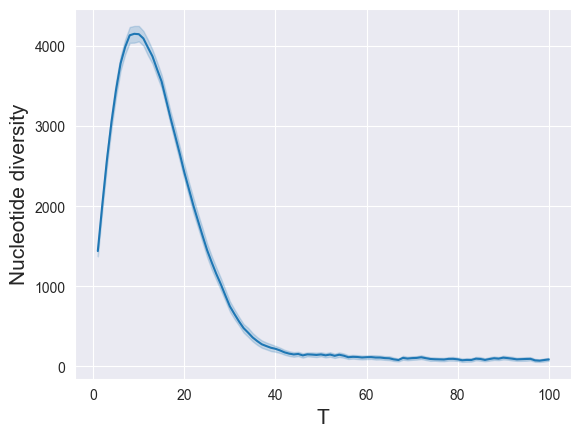

CPU times: total: 2.92 s
Wall time: 2.94 s


In [5]:
%%time

plot = sns.lineplot(data=pd.DataFrame(data),
             x='T',
             y='nucleotide diversity',
             errorbar=('ci', 95))
plot.set_xlabel('T', fontsize='15')
plot.set_ylabel('Nucleotide diversity', fontsize='15')

plt.savefig('../plots/population_diversity_evolution.png')
plt.show()